In [1]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt 
import numpy as np 

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Prepare MNIST Data for Training

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
# Define the preprocessing transformation
class BinaryTransform:
    def __call__(self, x):
        # Convert the image to a numpy array, normalize to [0, 1], and apply the threshold
        x = np.array(x) / 255.0  # Normalize pixel values to [0, 1]
        x = (x >= 0.3).astype(np.float32)  # Apply threshold to convert to binary (0s and 1s)
        return torch.from_numpy(x)  # Convert back to PyTorch tensor

# Create the transform with binary conversion
transform = transforms.Compose([
    BinaryTransform(),  # Apply the custom binary transformation
])
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [13]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: mnist_data
     Split: Train
     StandardTransform
 Transform: Compose(
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: mnist_data
     Split: Test
     StandardTransform
 Transform: Compose(
            ))

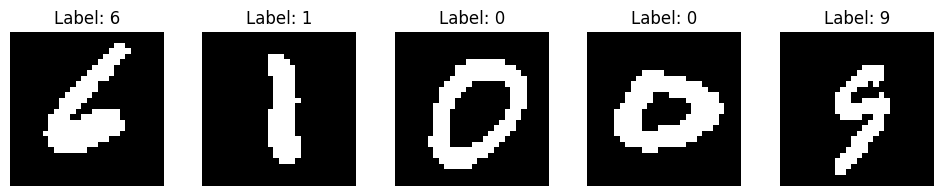

In [21]:
# Function to display a grid of images
def show_images(images, labels, title="MNIST Images"):
    images = images.numpy()  # Convert torch tensor to NumPy array
    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    for i, ax in enumerate(axes):
        ax.imshow(np.squeeze(images[i]), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')  # Hide axis
    plt.show()

# Get a batch of training data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 5 images
show_images(images[:5], labels[:5])

## Simple Feed Forward Neural Network

In [23]:
class MNISTChar(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), 
            nn.Sigmoid(), 
            nn.Linear(512, 512), 
            nn.ReLU(),
            nn.Linear(512,10), 
            #nn.SoftMax(), 
        )

    def forward(self, x):
        x  = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits 




In [24]:
import torch.optim as optim 
from tqdm import tqdm
model = MNISTChar().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

In [25]:
model

MNISTChar(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Convolutional NN

## The Training Loop

In [26]:
def train(model, criterion, optimizer,train_loader, val_loader,  epochs = 10):
   # Training and validation loop
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):  # Train for 5 epochs
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for batch in progress_bar:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())  
        
        # Compute average training loss
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
       
       # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch[0].to(device), batch[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Get the predicted labels
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct / len(val_subset)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

In [27]:
train_losses, val_losses, val_accuracies = train(model, criterion, optimizer, train_loader, val_loader, epochs=10)


Epoch 1/10: 100%|██████████| 750/750 [00:03<00:00, 196.79batch/s, loss=0.0841]


Epoch [1/10], Train Loss: 0.3013, Validation Loss: 0.1852, Validation Accuracy: 0.9483


Epoch 2/10: 100%|██████████| 750/750 [00:03<00:00, 204.03batch/s, loss=0.0614] 


Epoch [2/10], Train Loss: 0.1824, Validation Loss: 0.1898, Validation Accuracy: 0.9468


Epoch 3/10: 100%|██████████| 750/750 [00:03<00:00, 200.76batch/s, loss=0.0648]


Epoch [3/10], Train Loss: 0.1584, Validation Loss: 0.1856, Validation Accuracy: 0.9533


Epoch 4/10: 100%|██████████| 750/750 [00:03<00:00, 200.10batch/s, loss=0.141]  


Epoch [4/10], Train Loss: 0.1403, Validation Loss: 0.1639, Validation Accuracy: 0.9582


Epoch 5/10: 100%|██████████| 750/750 [00:03<00:00, 200.63batch/s, loss=0.277]  


Epoch [5/10], Train Loss: 0.1277, Validation Loss: 0.2376, Validation Accuracy: 0.9501


Epoch 6/10: 100%|██████████| 750/750 [00:03<00:00, 198.95batch/s, loss=0.113]  


Epoch [6/10], Train Loss: 0.1244, Validation Loss: 0.1714, Validation Accuracy: 0.9592


Epoch 7/10: 100%|██████████| 750/750 [00:03<00:00, 201.05batch/s, loss=0.0673] 


Epoch [7/10], Train Loss: 0.1089, Validation Loss: 0.1730, Validation Accuracy: 0.9548


Epoch 8/10: 100%|██████████| 750/750 [00:03<00:00, 200.20batch/s, loss=0.0445]  


Epoch [8/10], Train Loss: 0.1033, Validation Loss: 0.1868, Validation Accuracy: 0.9569


Epoch 9/10: 100%|██████████| 750/750 [00:03<00:00, 199.90batch/s, loss=0.14]   


Epoch [9/10], Train Loss: 0.0997, Validation Loss: 0.2067, Validation Accuracy: 0.9582


Epoch 10/10: 100%|██████████| 750/750 [00:03<00:00, 202.19batch/s, loss=0.067]  


Epoch [10/10], Train Loss: 0.1015, Validation Loss: 0.2013, Validation Accuracy: 0.9562


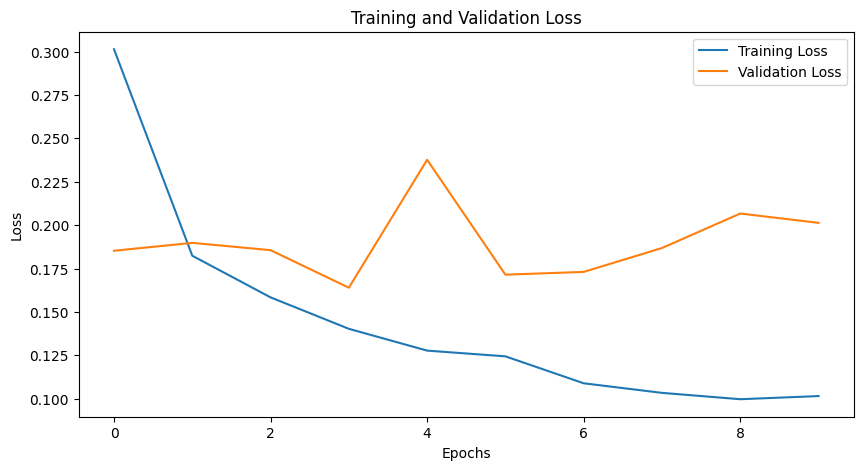

In [28]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Evaluation

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


In [30]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

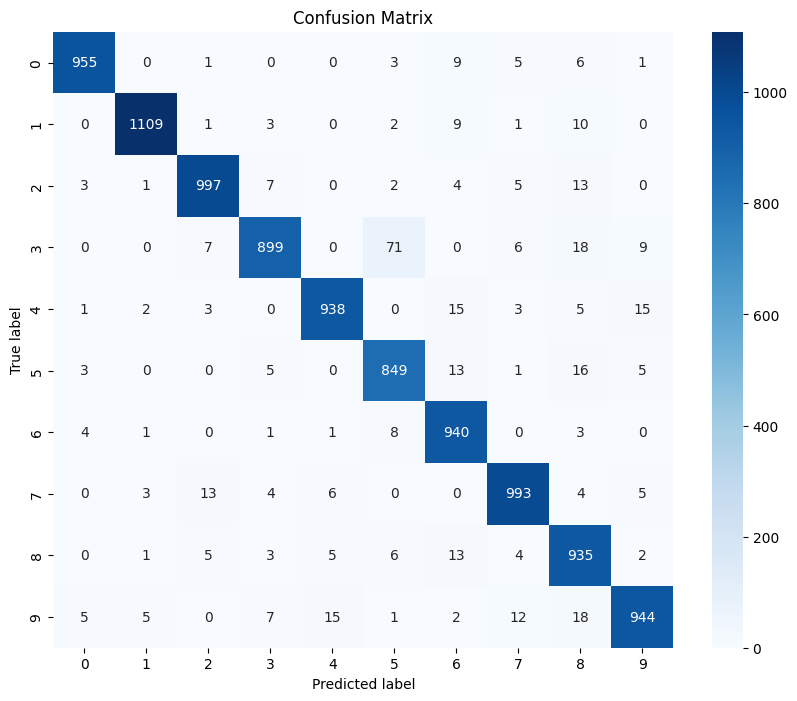

In [31]:
y_true, y_pred = evaluate_model(model, test_loader)
classes = [str(i) for i in range(10)]  # Class names for MNIST (0-9)
plot_confusion_matrix(y_true, y_pred, classes)

In [32]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get the predicted labels
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_dataset)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Test the trained model
test(model, test_loader)

Test Loss: 0.1914, Test Accuracy: 0.9559


In [116]:
# Assuming `dataloader` is your DataLoader object
data_iter = iter(test_loader)

# Get the first batch of images and labels
images, labels = next(data_iter)

# Extract the first image and its label from the batch
single_image = images[0]
single_label = labels[0]

# Display the shape of the image
print("Image shape:", single_image.shape)
print("Label:", single_label)


Image shape: torch.Size([1, 28, 28])
Label: tensor(7)


In [118]:
output = model(single_image.to(device))

In [119]:
output

tensor([[-21.8901,   0.1444,  -2.1180,  -5.7034,  -0.5495,  -1.6681, -12.3653,
          12.2284,  -8.2639,   2.9288]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [33]:
# Export the model to TorchScript
device = torch.device('cpu')
model.to(device)
example = torch.rand(1,28, 28).to(device)
model.eval()  # Set the model to evaluation mode
scripted_model = torch.jit.trace(model,example)  # Use torch.jit.trace for tracing if needed
scripted_model.save('mnist_model.pt')  # Save the model

In [137]:
import pandas as pd
import numpy as np

# Read the data from the CSV file into a DataFrame
im1 = pd.read_csv('matrix.csv', header=None)  # Use header=None to prevent the first row from being interpreted as column names

# Convert the DataFrame to a NumPy array
im1 = im1.to_numpy().flatten()  # Flatten to ensure it's a 1D array

# Reshape the flattened array into a 28x28 matrix
if im1.size == 28 * 28:  # Ensure the data has the correct size
    im1 = im1.reshape(28, 28)  # Reshape into (1, 28, 28) format for further processing
else:
    print(f"Error: Expected 784 values, but found {im1.size}.")

In [136]:
im1.shape

(1, 28, 28)

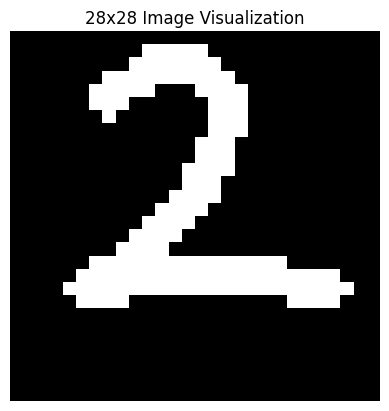

In [138]:
# Visualize the image using matplotlib
plt.imshow(im1, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title('28x28 Image Visualization')
plt.axis('off')  # Hide axis ticks
plt.show()  # Display the image